In [2]:
# 实战Kaggle⽐赛：狗的品种识别（ImageNet Dogs）
''' 
本节我们将在Kaggle上实战狗品种识别问题.本次⽐赛网址是https://www.kaggle.com/c/dog-breed-
identification。图13.14.1显⽰了鉴定⽐赛网⻚上的信息。你需要⼀个Kaggle账⼾才能提交结果
在这场⽐赛中，我们将识别120类不同品种的狗。这个数据集实际上是著名的ImageNet的数据集⼦集。与
13.13节中CIFAR-10数据集中的图像不同，ImageNet数据集中的图像更⾼更宽，且尺⼨不⼀
'''
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
#@save
d2l.DATA_HUB['dog_tiny'] = (
    f'{d2l.DATA_URL}kaggle_dog_tiny.zip',
    '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d',
)
# 如果使用Kaggle⽐赛的完整数据集，请将下⾯的变量更改为False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [4]:
# 整理数据集
''' 
我们可以像 13.13节中所做的那样整理数据集，即从原始训练集中拆分验证集，然后将图像移动到按标签分
组的子文件夹中。
下⾯的reorg_dog_data函数读取训练数据标签、拆分验证集并整理训练集
'''
def reorg_dog_data(data_dir, valid_ratio): # 重组数据集
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)
    
batch_size = 32 if demo else 128 # 批大小
valid_ratio = 0.1 # 验证集比例
reorg_dog_data(data_dir, valid_ratio) # 重组

In [5]:
# 图像增广 -> 训练
'''
回想⼀下，这个狗品种数据集是ImageNet数据集的子集，其图像大于 13.13节中CIFAR-10数据集的图像。下
⾯我们看⼀下如何在相对较⼤的图像上使用图像增广
'''
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始⾯积的0.08〜1之间，⾼宽⽐在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), # 随机剪裁
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(), # 随机水平翻转
    # 随机更改亮度，对⽐度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])]) # mean, std

In [7]:
'测试时，我们只使用确定性的图像预处理操作'
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中⼼裁切224x224⼤小的图⽚
    torchvision.transforms.CenterCrop(224), # 中心裁剪
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])]) # 标准化

In [9]:
# 读取数据集
'与 13.13节⼀样，我们可以读取整理后的含原始图像⽂件的数据集'
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [10]:
'下⾯我们创建数据加载器实例的⽅式与 13.13节相同'
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)] # 创建数据加载器

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [11]:
# 微调预训练模型
'''同样，本次比赛的数据集是ImageNet数据集的子集。因此，我们可以使用 13.2节中讨论的方法在完
整ImageNet数据集上选择预训练的模型，然后使用该模型提取图像特征，以便将其输⼊到定制的小规模输出
网络中。深度学习框架的高级API提供了在ImageNet数据集上预训练的各种模型。在这⾥，我们选择预训练
的ResNet-34模型，我们只需重复使用此模型的输出层(即提取的特征)的输入。然后，我们可以用⼀个可以
训练的小型自定义输出网络替换原始输出层，例如堆叠两个完全连接的图层。与 13.2节中的实验不同，以下
内容不重新训练用于特征提取的预训练模型，这节省了梯度下降的时间和内存空间。
回想⼀下，我们使用三个RGB通道的均值和标准差来对完整的ImageNet数据集进⾏图像标准化。事实上，这
也符合ImageNet上预训练模型的标准化操作
'''
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True) # 使用预训练模型
    # 定义⼀个新的输出网络，共有120个输出类别 -> 只训练这个模型
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120)) # 重新构建输出层
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False # 不需重新训练,所以不需要梯度下降
    return finetune_net

In [12]:
'''在计算损失之前，我们首先获取预训练模型的输出层的输入，即提取的特征。然后我们使用此特征作为我们
小型自定义输出网络的输入来计算损失
'''
loss = nn.CrossEntropyLoss(reduction='none')
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features) # 使用预训练模型的特征作为输出网络的输入计算损失
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [13]:
# 定义训练模型
'''
我们将根据模型在验证集上的表现选择模型并调整超参数。模型训练函数train只迭代小型自定义输出网络
的参数
'''
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd) # 随机梯度下降
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay) # 优化策略
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend) # 动画
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start() # 开始计时
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad() # 梯度归零
            output = net(features)
            l = loss(output, labels).sum() # 计算损失
            l.backward() # 反向传播
            trainer.step() # 停止训练
            metric.add(l, labels.shape[0]) # 指标
            timer.stop() # 计时停止
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None)) # 展示动画
        measures = f'train loss {metric[0] / metric[1]:.3f}' # 测量
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step() # 验证集不使用优化策略
        
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(
        f'{measures}\n{metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}'
    )

train loss 0.978, valid loss 1.536
411.7 examples/sec on [device(type='cuda', index=0)]


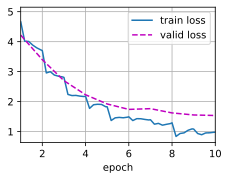

In [14]:
# 训练和验证模型
'''
现在我们可以训练和验证模型了，以下超参数都是可调的。例如，我们可以增加迭代轮数。另外，由
于lr_period和lr_decay分别设置为2和0.9，因此优化算法的学习速率将在每2个迭代后乘以0.9
'''
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay) # 训练

train loss 1.028
480.2 examples/sec on [device(type='cuda', index=0)]


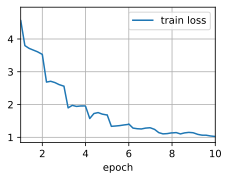

In [17]:
# 对测试集分类并在Kaggle提交结果
''' 
与 13.13节中的最后⼀步类似，最终所有标记的数据（包括验证集）都用于训练模型和对测试集进行分类。我
们将使用训练好的⾃定义输出网络进行分类
以下代码将生成⼀个submission.csv⽂件，以 4.10节中描述的⽅式提在Kaggle上提交
'''
net = get_net(devices)
# 使用整体数据集进行重新训练
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

In [ ]:
'''小结
• ImageNet数据集中的图像⽐CIFAR-10图像尺⼨大，我们可能会修改不同数据集上任务的图像增广操作。
• 要对ImageNet数据集的⼦集进行分类，我们可以利用完整ImageNet数据集上的预训练模型来提取特征
并仅训练小型自定义输出网络，这将减少计算时间和节省内存空间
'''